# EMA RSI Strategy

In [119]:
from datetime import datetime, timedelta
import logging

from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
import pandas as pd
from talib import ATR, EMA, RSI

from examples.data import (
    download_bars,
    separate_bars_by_symbol,
    split_multi_index_bars_train_test,
)

from bacta.backtester import EventBacktester, Order, Position
from bacta.utilities import dash
from bacta.utilities.logger import get_logger, set_log_level

set_log_level(logging.DEBUG)

In [120]:
class EmaStrategy(EventBacktester):
    """
    Backtester that uses the Keltner Channel to make decisions.
    """

    def __init__(self, active_symbols, cash, **kwargs):
        super().__init__(active_symbols, cash, **kwargs)
        self.short_ema_period = 21
        self.long_ema_period = 200
        self.rsi_period = 14

    def precompute_step(self, bars: pd.DataFrame):
        """
        Preload the indicators for the backtest.
        """

        split_bars = separate_bars_by_symbol(bars)

        self.short_emas = {
            symbol: EMA(
                split_bars[symbol].loc[:,
                                       "close"], timeperiod=self.short_ema_period
            )
            for symbol in self.active_symbols
        }
        self.long_emas = {
            symbol: EMA(
                split_bars[symbol].loc[:,
                                       "close"], timeperiod=self.long_ema_period
            )
            for symbol in self.active_symbols
        }
        self.rsis = {
            symbol: RSI(split_bars[symbol].loc[:, "close"],
                        timeperiod=self.rsi_period)
            for symbol in self.active_symbols
        }

    def update_step(self, bars: pd.DataFrame, index: pd.Timestamp):
        """
        Update the state of the backtester.
        """
        split_bars = separate_bars_by_symbol(bars)

        self.short_emas = {
            symbol: EMA(
                split_bars[symbol].loc[:,
                                       "close"], timeperiod=self.short_ema_period
            )
            for symbol in self.active_symbols
        }
        self.long_emas = {
            symbol: EMA(
                split_bars[symbol].loc[:,
                                       "close"], timeperiod=self.long_ema_period
            )
            for symbol in self.active_symbols
        }
        self.rsis = {
            symbol: RSI(split_bars[symbol].loc[:, "close"],
                        timeperiod=self.rsi_period)
            for symbol in self.active_symbols
        }

    def generate_orders(self, bar: pd.DataFrame, index: pd.Timestamp) -> list[Order]:
        """
        Make a decision based on the prices.
        """
        close_prices = bar.loc[:, "close"]
        # short ema is 21, long ema is 200
        # rsi is 14
        # if rsi is > 75 and short ema is > long ema, then short
        # if rsi is < 25 and short ema is < long ema, then long
        orders = []
        for symbol in self.active_symbols:
            quantity = round(200 / close_prices[symbol], 4)
            if (
                self.rsis[symbol][index] > 70
                and self.short_emas[symbol][index] > self.long_emas[symbol][index]
            ) and self.get_position(symbol) > -10:
                orders.append(
                    Order(symbol, Position.SHORT,
                          close_prices[symbol], quantity)
                )
            elif (
                self.rsis[symbol][index] < 30
                and self.short_emas[symbol][index] < self.long_emas[symbol][index]
            ) and self.get_position(symbol) < 10:
                orders.append(
                    Order(symbol, Position.LONG,
                          close_prices[symbol], quantity)
                )

        return orders


In [121]:
symbols = ["CMS", "DUK", "AAPL"]

bars = download_bars(
    symbols,
    start_date=datetime(2024, 1, 1),
    end_date=datetime(2025, 7, 31),
    timeframe=TimeFrame(1, TimeFrameUnit.Hour)
)
# split the bars into train and test
train_bars, test_bars = split_multi_index_bars_train_test(
    bars, split_ratio=0.82)

# create the backtester
backtester = EmaStrategy(
    symbols,
    cash=2000,
    allow_short=True,
    allow_overdraft=False,
    min_cash_balance=200,
    min_trade_value=1,
    market_hours_only=True,
    transaction_cost=0.0025,
    transaction_cost_type="percentage",
)

# preload the train bars
backtester.load_train_bars(train_bars)

# run_backtest the backtest
backtester.run_backtest(test_bars)

# plot the order and state history
print(dash("order history"))
print(backtester.get_history())
print(dash("state history"))
print(backtester.get_state_history())

[2025-08-13 22:31:50][DEBUG] Loading data/CMSDUKAAPL_2024-01-01_2025-07-31_1Hour.pkl
[2025-08-13 22:31:50][DEBUG] Initializing backtester with active symbols: ['CMS', 'DUK', 'AAPL'], cash: 2000, allow_short: True, allow_overdraft: False, min_cash_balance: 200, min_trade_value: 1, market_hours_only: True
[2025-08-13 22:31:50][INFO] Train bars have been previously loaded. Concatenating with test bars...
[2025-08-13 22:31:50][INFO] Running backtest over 30100 bars from 2025-04-18 03:00:00-04:00 to 2025-07-30 16:00:00-04:00...
[2025-08-13 22:31:51][DEBUG] Placing LONG 1.0469 AAPL @ $191.040 + $0.500 TC (2025-04-21 10:00:00-04:00)
[2025-08-13 22:31:51][DEBUG] Placing LONG 1.0537 AAPL @ $189.800 + $0.500 TC (2025-04-21 11:00:00-04:00)
[2025-08-13 22:31:51][DEBUG] Placing LONG 1.0509 AAPL @ $190.310 + $0.500 TC (2025-04-21 12:00:00-04:00)
[2025-08-13 22:31:51][DEBUG] Placing LONG 1.0523 AAPL @ $190.060 + $0.500 TC (2025-04-21 13:00:00-04:00)
[2025-08-13 22:31:51][DEBUG] Placing LONG 2.8273 CM

- order history ----------------------------------------------------------------
                          symbol  position   price  quantity
2025-04-21 10:00:00-04:00   AAPL         1  191.04    1.0469
2025-04-21 11:00:00-04:00   AAPL         1  189.80    1.0537
2025-04-21 12:00:00-04:00   AAPL         1  190.31    1.0509
2025-04-21 13:00:00-04:00   AAPL         1  190.06    1.0523
2025-04-21 14:00:00-04:00    CMS         1   70.74    2.8273
...                          ...       ...     ...       ...
2025-07-30 14:00:00-04:00   AAPL         1  208.11    0.9610
2025-07-30 15:00:00-04:00   AAPL         1  208.78    0.9579
2025-07-30 16:00:00-04:00    CMS         1   71.64    1.7703
2025-07-30 16:00:00-04:00    DUK         1  119.56    2.4759
2025-07-30 16:00:00-04:00   AAPL         1  208.00    0.7659

[194 rows x 4 columns]
- state history ----------------------------------------------------------------
                                  cash  portfolio_value     CMS     DUK  \
0      

In [122]:
# plot the performance
print(dash("performance"))
print(backtester.pretty_format_performance())

- performance ------------------------------------------------------------------
Backtest Performance:
- Return on Investment: 18.67%
- vs. Buy and Hold Return: 1.41%
- Sharpe Ratio: 0.52
- Max Drawdown Percentage: 6.18%

- Start Portfolio Value: $2000.00
- End Portfolio Value: $2373.34
- Min Portfolio Value: $1994.98
- Max Portfolio Value: $2389.84
- Min Cash Balance: $-0.99
- Max Cash Balance: $6568.55
- Win Rate: 93.19%

- Number of Orders: 194
- Number of Winning Trades: 178
- Number of Losing Trades: 13
- Avg Trade Return: 2.41%
- Largest Win: 10.10% ($15.58)
- Largest Loss: -2.37% ($-2.83)
- Max Consecutive Wins: 9
- Max Consecutive Losses: 1

- Trading Period Start: 2025-04-18 03:00:00-04:00
- Trading Period End: 2025-07-30 16:00:00-04:00
- Trading Period Length: 103 days 13:00:00
- Time in Market: 96.74%


plotting...


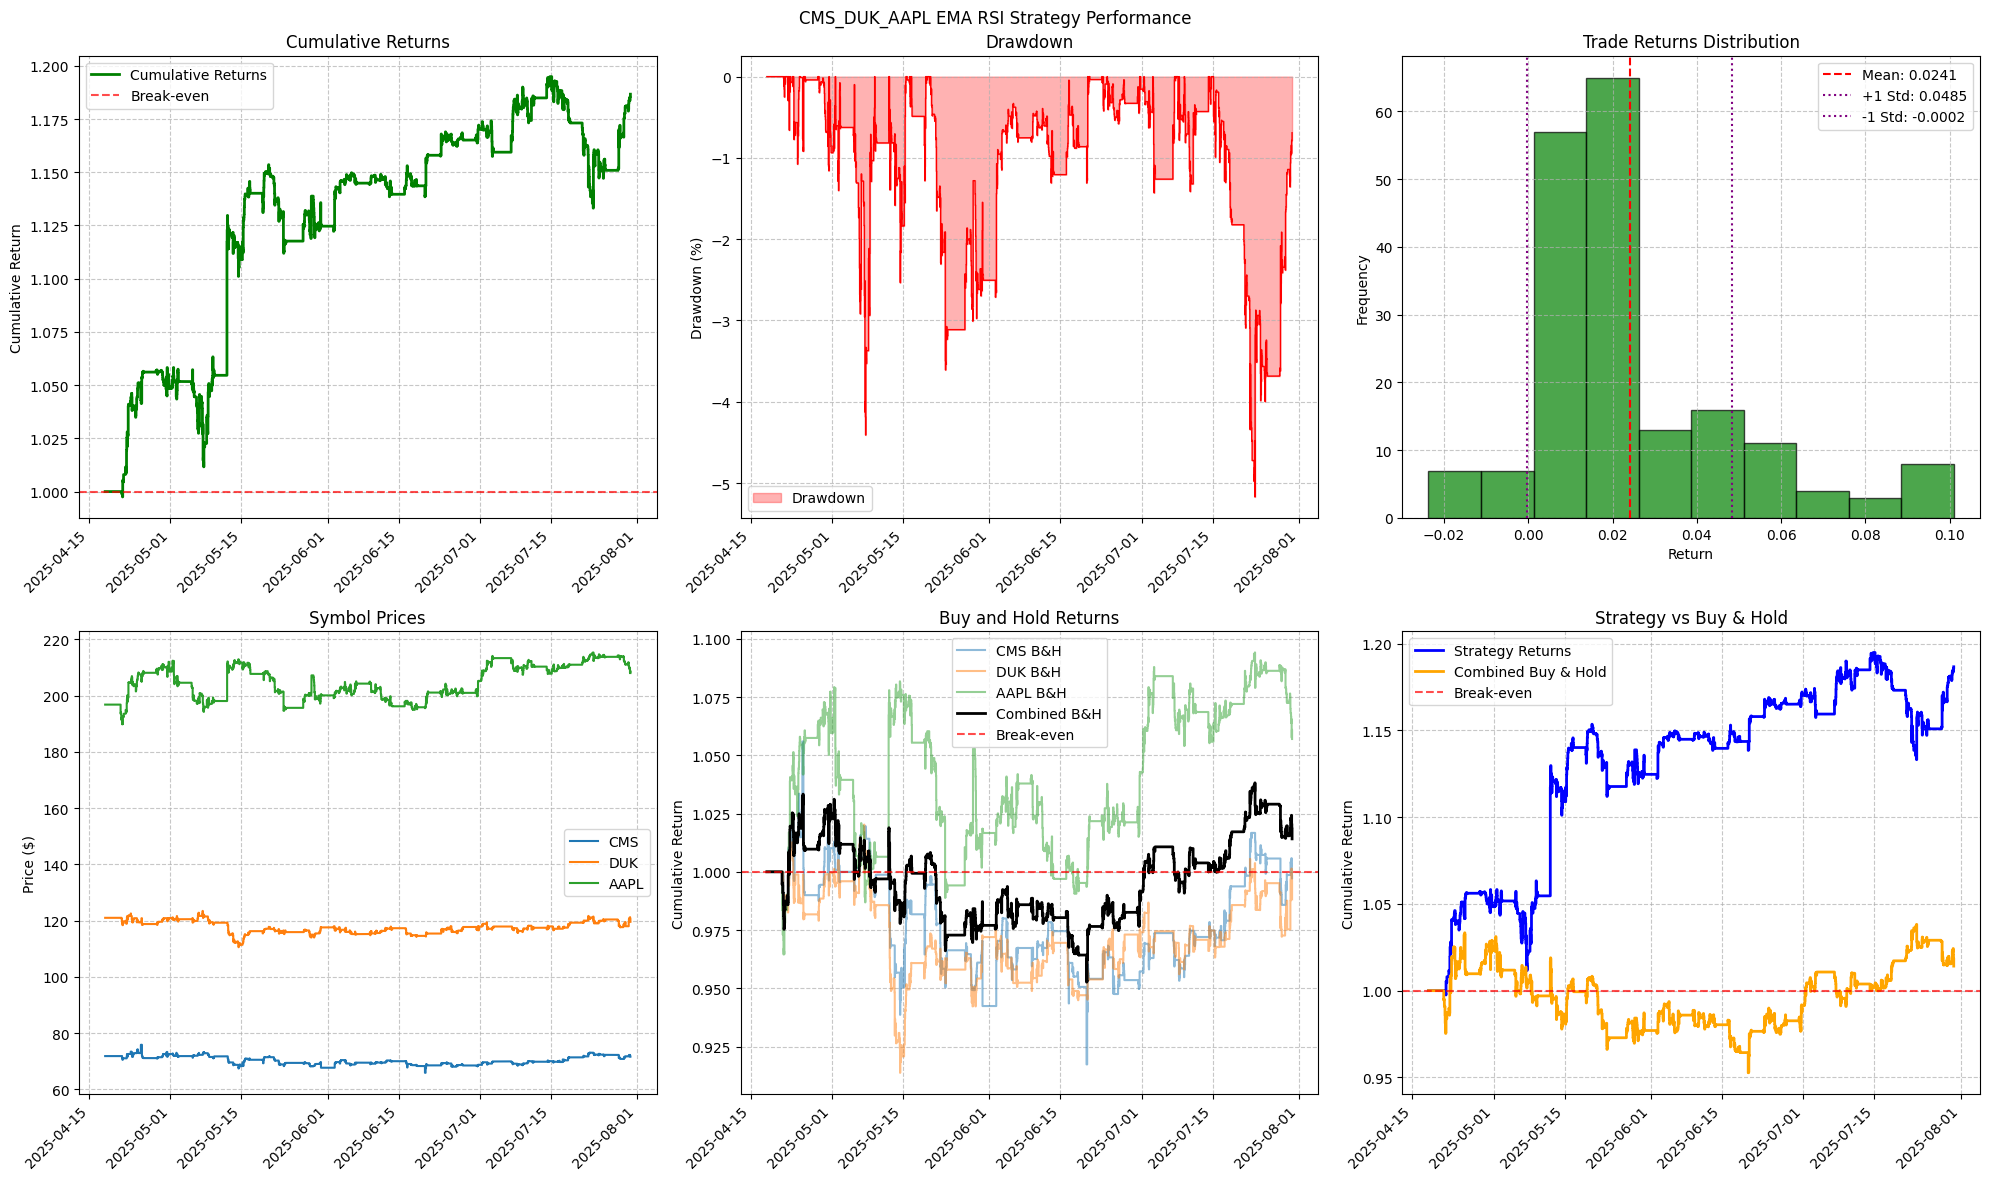

In [123]:
# Plot the results
print("plotting...")
backtester.plot_performance_analysis(
    title="_".join(symbols) + " EMA RSI Strategy Performance", show_plot=False)

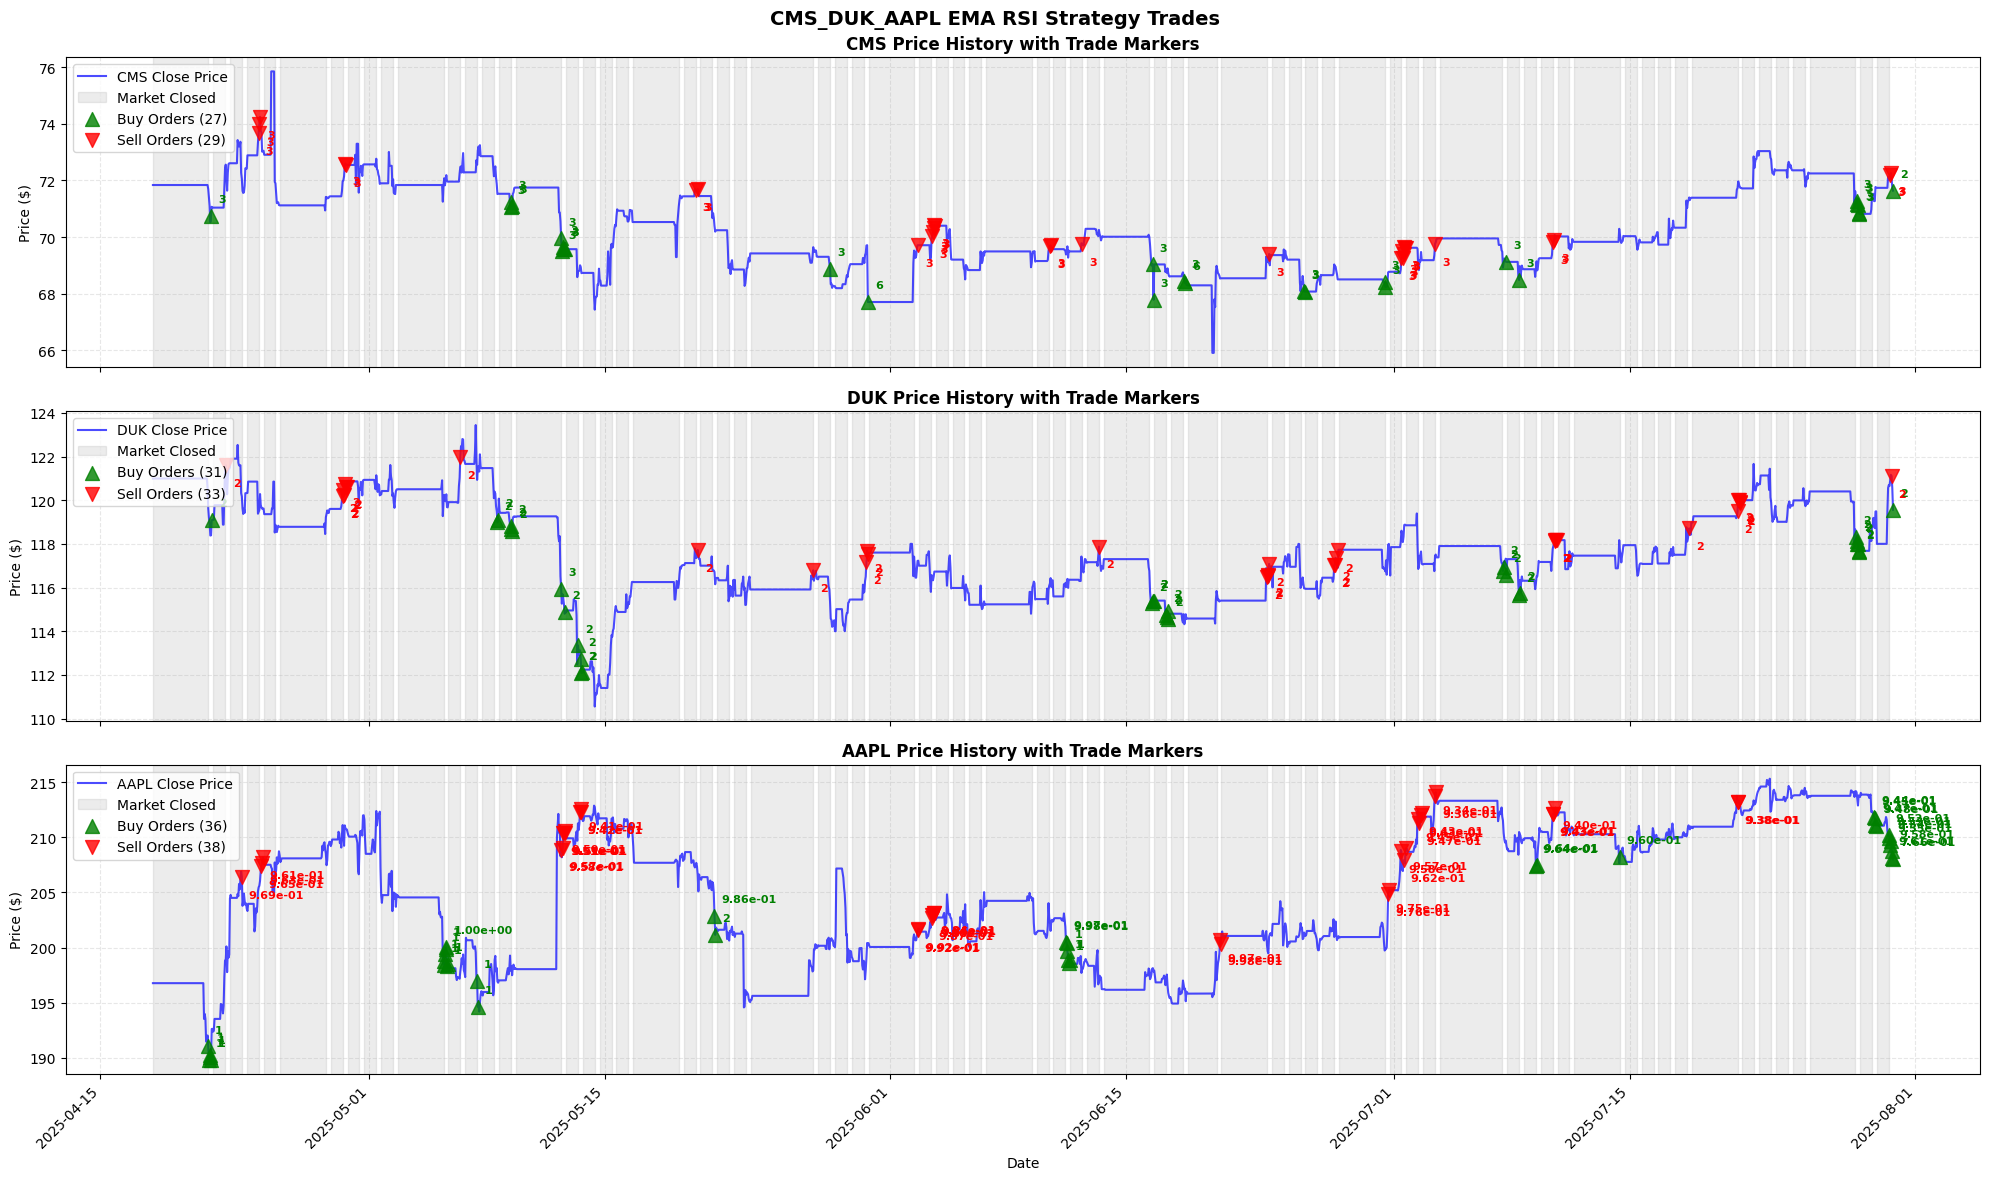

In [124]:
backtester.plot_trade_history(title="_".join(
    symbols) + " EMA RSI Strategy Trades", show_plot=False)

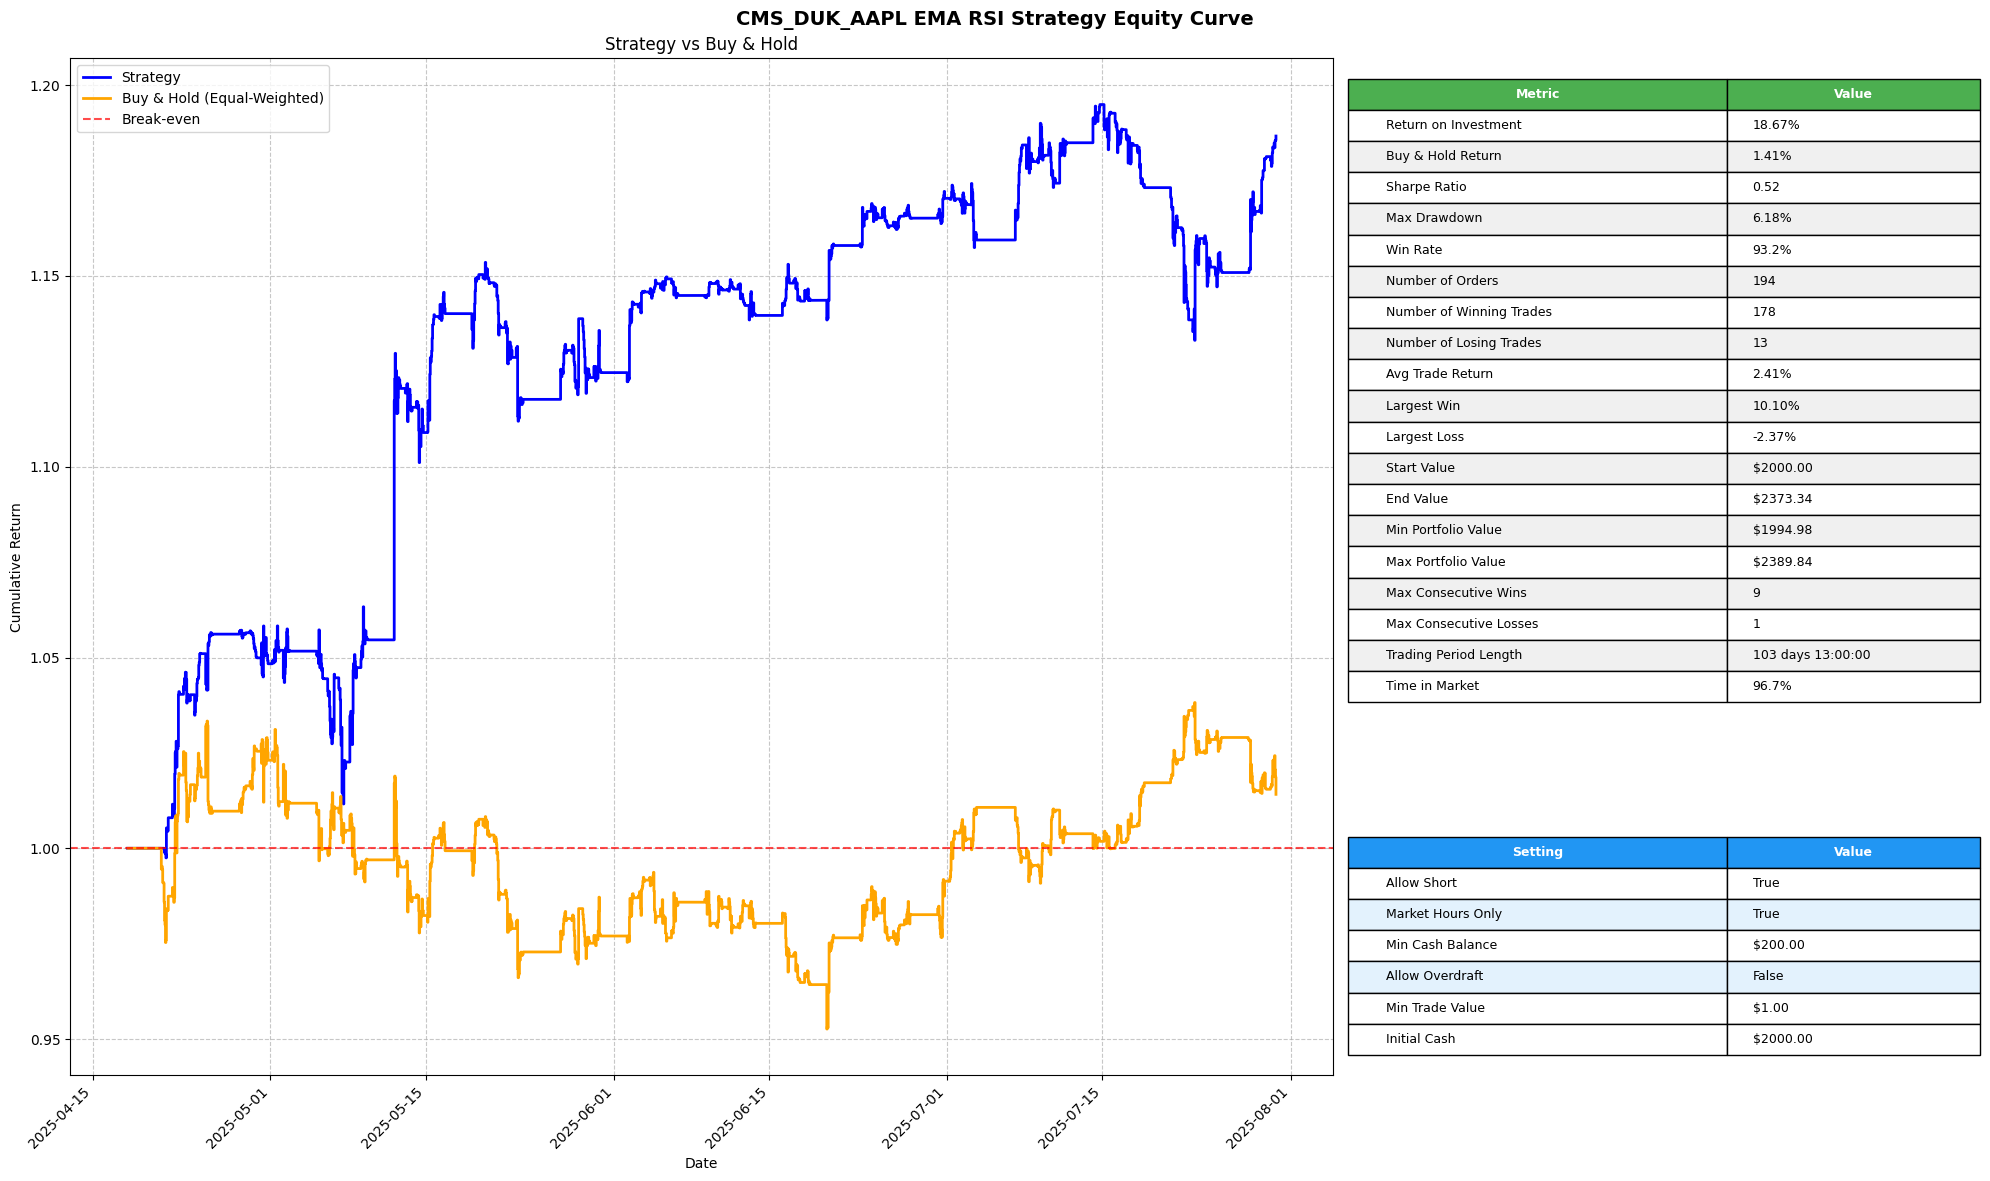

In [125]:
backtester.plot_equity_curve(
    title="_".join(symbols) + " EMA RSI Strategy Equity Curve", show_plot=False
)